This package implements the basic machinery for decorrelated backpropagation.

In [1]:
import numpy as np
import torch
from decorrelation import covariance, DecorrelationPatch2d, DecorrelationFC
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [5]:
num_samples=1000
num_features=20

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

In [6]:
# load from dataset

# data_path = '~/Data'
# num_samples=1000
# num_features=784

# data = MNIST(root=data_path, train=True, download=True).data
# data = data[np.random.permutation(len(data))[:num_samples]].to(torch.float32)

# data /= 255
# data -= torch.mean(data, axis=0)
# data = data.reshape(num_samples, -1)

We start by showing effective decorrelation of correlated input

iteration 0; average off-diagonal covariance: 0.243851
iteration 1; average off-diagonal covariance: 0.241964
iteration 2; average off-diagonal covariance: 0.240109
iteration 3; average off-diagonal covariance: 0.238285
iteration 4; average off-diagonal covariance: 0.236491
iteration 5; average off-diagonal covariance: 0.234728
iteration 6; average off-diagonal covariance: 0.232993
iteration 7; average off-diagonal covariance: 0.231287
iteration 8; average off-diagonal covariance: 0.229608
iteration 9; average off-diagonal covariance: 0.227956
iteration 10; average off-diagonal covariance: 0.226330
iteration 11; average off-diagonal covariance: 0.224730
iteration 12; average off-diagonal covariance: 0.223156
iteration 13; average off-diagonal covariance: 0.221605
iteration 14; average off-diagonal covariance: 0.220079
iteration 15; average off-diagonal covariance: 0.218576
iteration 16; average off-diagonal covariance: 0.217096
iteration 17; average off-diagonal covariance: 0.215638
it

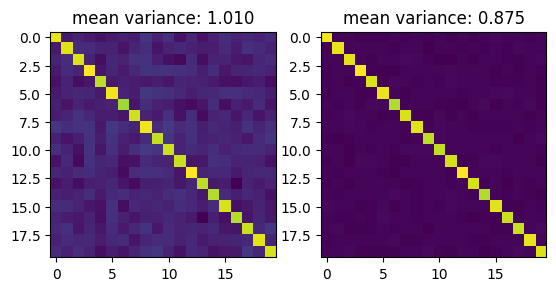

In [10]:

# create a fully connected decorrelator
model = DecorrelationFC(num_features, whiten=False)

# correlation matrix before training
A1 = model.covariance(model.forward(data))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-3 * model.R.grad
    print(f'iteration {i}; average off-diagonal covariance: {covariance([model])[0].numpy():3f}')

# correlation matrix after training
A2 = model.covariance(model.forward(data))

plt.subplot(1,2,1)
plt.imshow(A1)
plt.title(f'mean variance: {torch.mean(torch.diag(A1)):.3f}')
plt.subplot(1,2,2)
plt.imshow(A2)
plt.title(f'mean variance: {torch.mean(torch.diag(A2)):.3f}');


Decorrelation of correlated input represented in convolutional [N, C, H, W] form

In [ ]:
plt.imshow(model.R);

AttributeError: 'DecorrelationFC' object has no attribute 'R'

iteration 0; average patchwise off-diagonal correlation: 0.966233
iteration 1; average patchwise off-diagonal correlation: 0.675423
iteration 2; average patchwise off-diagonal correlation: 0.533109
iteration 3; average patchwise off-diagonal correlation: 0.445397
iteration 4; average patchwise off-diagonal correlation: 0.385081
iteration 5; average patchwise off-diagonal correlation: 0.340754
iteration 6; average patchwise off-diagonal correlation: 0.306667
iteration 7; average patchwise off-diagonal correlation: 0.279570
iteration 8; average patchwise off-diagonal correlation: 0.257479
iteration 9; average patchwise off-diagonal correlation: 0.239102
iteration 10; average patchwise off-diagonal correlation: 0.223564
iteration 11; average patchwise off-diagonal correlation: 0.210247
iteration 12; average patchwise off-diagonal correlation: 0.198701
iteration 13; average patchwise off-diagonal correlation: 0.188594
iteration 14; average patchwise off-diagonal correlation: 0.179669
itera

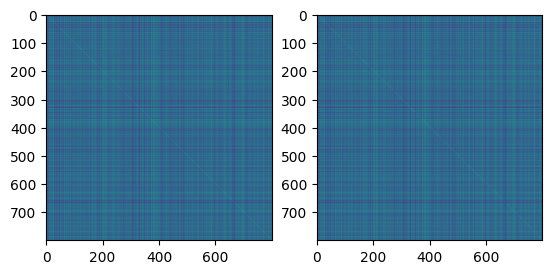

In [ ]:
# generate [N, M] correlated input
num_examples=100
num_channels=2
height=20
width=20
num_features=num_channels*height*width
kernel_size=(3,3)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
x = d.sample((num_examples,))

# transform to [N, C, H, W] correlated input
x = x.reshape(num_examples,num_channels,height,width)

model = DecorrelationPatch2d(2, kernel_size=kernel_size)

# correlation matrix before training
C1 = DecorrelationFC.correlation(model.forward(x).view(num_examples,-1))

# train decorrelator
for i in range(100):
    y = model.forward(x)
    model.update()
    model.R -= 1e-2 * model.R.grad
    print(f'iteration {i}; average patchwise off-diagonal correlation: {mean_correlation([model]).numpy():3f}')

# correlation matrix after training
C2 = DecorrelationFC.correlation(model.forward(x).view(num_examples,-1))

plt.subplot(1,2,1)
plt.imshow(C1)
plt.subplot(1,2,2)
plt.imshow(C2);

# does patchwise not translate into full size????

In [ ]:
C1

tensor([[1.1295, 0.9942, 0.9679,  ..., 0.9876, 1.0077, 0.9998],
        [0.9942, 1.0322, 0.9448,  ..., 0.9560, 0.9615, 0.9725],
        [0.9679, 0.9448, 1.0115,  ..., 0.9652, 0.9381, 0.9658],
        ...,
        [0.9876, 0.9560, 0.9652,  ..., 1.0835, 0.9497, 0.9811],
        [1.0077, 0.9615, 0.9381,  ..., 0.9497, 1.0462, 0.9532],
        [0.9998, 0.9725, 0.9658,  ..., 0.9811, 0.9532, 1.0622]])

In [ ]:
C2

tensor([[0.0740, 0.0651, 0.0634,  ..., 0.0646, 0.0659, 0.0654],
        [0.0651, 0.0676, 0.0618,  ..., 0.0625, 0.0628, 0.0636],
        [0.0634, 0.0618, 0.0662,  ..., 0.0631, 0.0613, 0.0631],
        ...,
        [0.0646, 0.0625, 0.0631,  ..., 0.0707, 0.0620, 0.0641],
        [0.0659, 0.0628, 0.0613,  ..., 0.0620, 0.0683, 0.0622],
        [0.0654, 0.0636, 0.0631,  ..., 0.0641, 0.0622, 0.0694]])